# Yongjie's CA2-Unsupervised Model

Name: Li Yongjie

ID: 2342377

Class: DAAA/FT/1B/01

## Objective
Use unsupervised learning to group the students into multiple clusters so that we can cater needs
for different students

<hr>

### Importing the neccessary libraries

In [118]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # Set this before importing sklearn

# Basic Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Sklearn Libraries
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



df = pd.read_csv("./Student_Performance_dataset.csv")

print(df.head(5))

   Student_ID  Gender  Age  English_Score  Math_Score  Science_Score
0           1  Female   18           64.0        56.0             60
1           2  Female   12           89.0        71.0             97
2           3  Female   18           69.0        69.0             80
3           4  Female   17           60.0        72.0             97
4           5    Male   13           71.0        76.0             76


In [119]:
sns.set_theme(palette='bright')
# Set the style for plots
plt.style.use('seaborn-v0_8-darkgrid')

<hr>

## Exploratory Data Analysis
<hr>

We will conduct an exploratory data analysis to gain insights into the characteristics of the dataset. Our focus will primarily be on understanding how each feature relates to the one another and try to identify paterns or trends.

This dataset pertains to student performance and contains 1000 data points with 6 columns:

*   **Student\_ID**: Unique identifier for each student
*   **Gender**: Student's gender
*   **Age**: Student's age
*   **English\_Score**: Student's score in English subject
*   **Math\_Score**: Student's score in Math subject
*   **Science\_Score**: Student's score in Science subject

Since Student ID is a unique identifier I dropped the column first

In [120]:
df.drop(columns='Student_ID', inplace=True)

### **Exploring Dataset**

In order to prevent our data set from being affected when exploring the dataset, we will create a copy of the original dataset

In [121]:
df_eda = df.copy()

In [122]:
# Get description 
df_eda.describe()

,Age,English_Score,Math_Score,Science_Score
count,1000.000000,971.000000,967.000000,1000.000000
mean,14.970000,76.089598,76.660807,76.370000
std,1.959832,12.767113,12.541226,12.866649
min,12.000000,55.000000,55.000000,55.000000
25%,13.000000,65.000000,66.000000,65.000000
50%,15.000000,76.000000,76.000000,77.000000
75%,17.000000,88.000000,87.500000,87.000000
max,18.000000,98.000000,98.000000,98.000000


In [123]:
df_eda.dtypes

Gender            object
Age                int64
English_Score    float64
Math_Score       float64
Science_Score      int64
dtype: object

In [124]:
df_eda['Gender'].unique()

array(['Female', 'Male', 'Genderqueer', 'Non-binary', 'Agender',
       'Bigender', 'Genderfluid', 'Polygender'], dtype=object)

In [125]:
df_eda.isnull().sum()

Gender            0
Age               0
English_Score    29
Math_Score       33
Science_Score     0
dtype: int64

In [126]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gender         1000 non-null   object 
 1   Age            1000 non-null   int64  
 2   English_Score  971 non-null    float64
 3   Math_Score     967 non-null    float64
 4   Science_Score  1000 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 39.2+ KB


Based on the information we collected, we can observe that the dataset we are working with contains 1000 rows and 4 columns (4 features).

We can tell that 3 features are numerical and that we have one categorical data that we need to handle. However, there are missing values for 2 of the columns which has to be handled with later on. Columns that have missing data includes, English Score - 29(2.9%), Math Score - 33(3.3%)

<hr>

### Univariate Analyisis
<hr>

Analysing our feature one at a time, to gain a better understanding of the feature and its distribution.

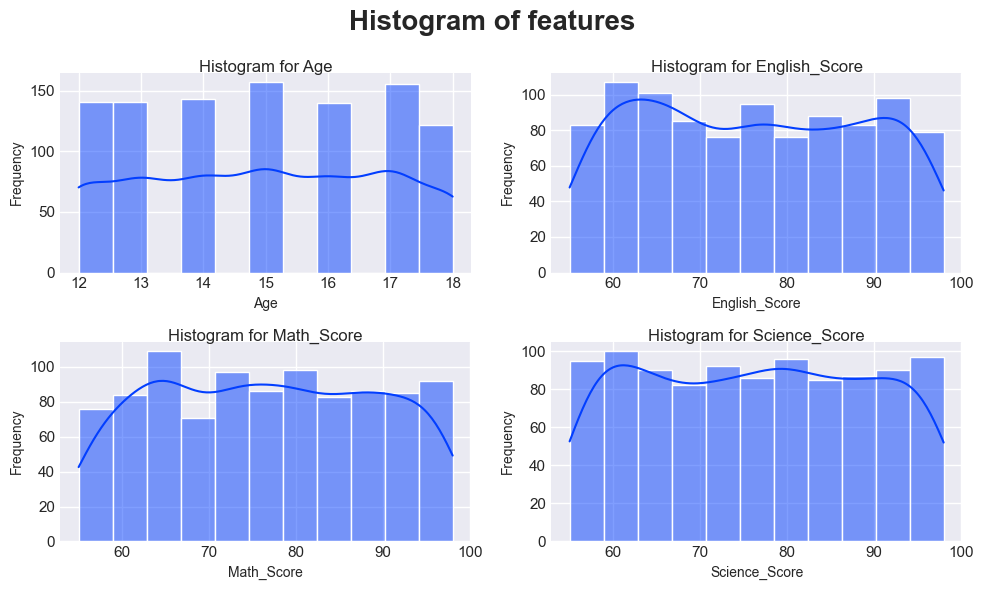

In [127]:
fig, axs = plt.subplots(2, 2 , tight_layout=False, figsize=(10, 6))

for i, (col, ax) in enumerate(zip(df_eda.columns[1:], axs.flatten())):
    sns.histplot(df[col], ax=ax, kde=True)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.set_title(f"Histogram for {col}", fontsize=12, pad=0.4)
    
plt.suptitle("Histogram of features", fontsize=20, fontweight='bold')
plt.show()

**Summary for feature's and it's graph**
<ol>
    <li>We can see that the distribution of each feature are similar in the sense that they all all almost equally distributed</li>
    <li>For scores we can observe that the scores are well-distributed over the range of 55-100</li>
    <li>For age we can observe that the ages are well-distributed over the range of 12-18</li>
</ol>


<u>Box Plot</u><br>
To observe outliers

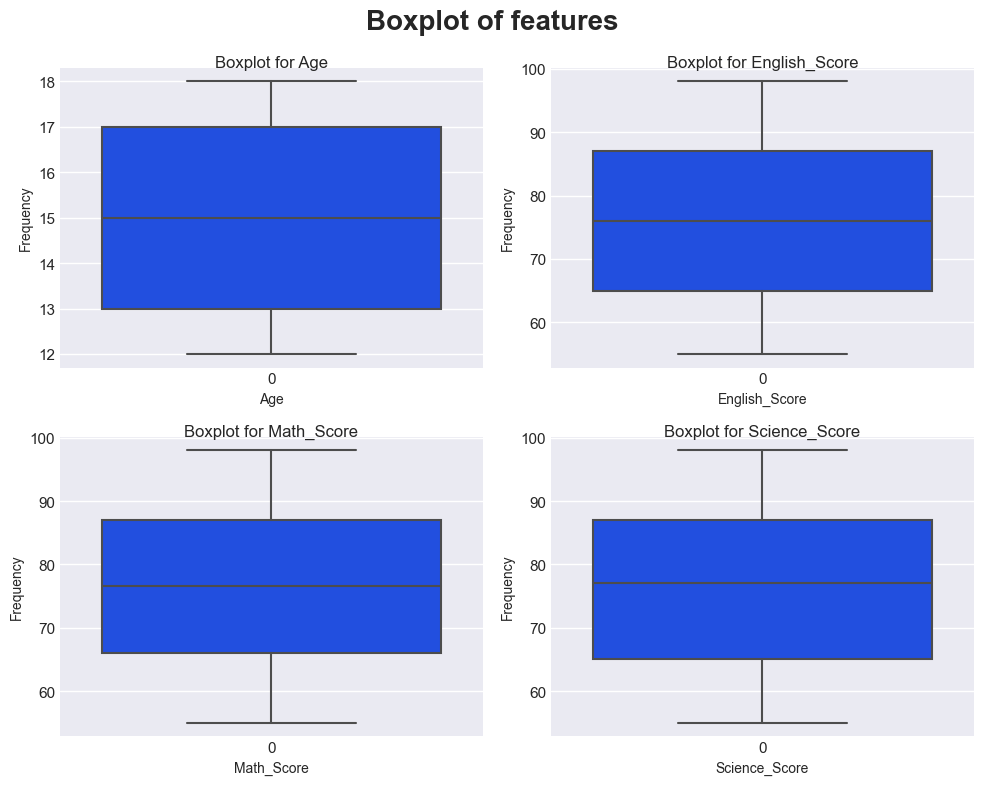

In [173]:
fig, axs = plt.subplots(2, 2 , tight_layout=False, figsize=(10, 8))

for i, (col, ax) in enumerate(zip(df_eda.columns[1:], axs.flatten())):
    sns.boxplot(df[col], ax=ax)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.set_title(f"Boxplot for {col}", fontsize=12, pad=0.4)
    
plt.suptitle("Boxplot of features", fontsize=20, fontweight='bold')
plt.show()

<u>Observation</u><br>

We can see that there are no outliers for every feature in our dataset , which is expected as the distribution was equal as seen from the histogram.
We can also see that median score for each subject is about 75-78

<u>Looking at our categorical Data</u>

To observe the distribution

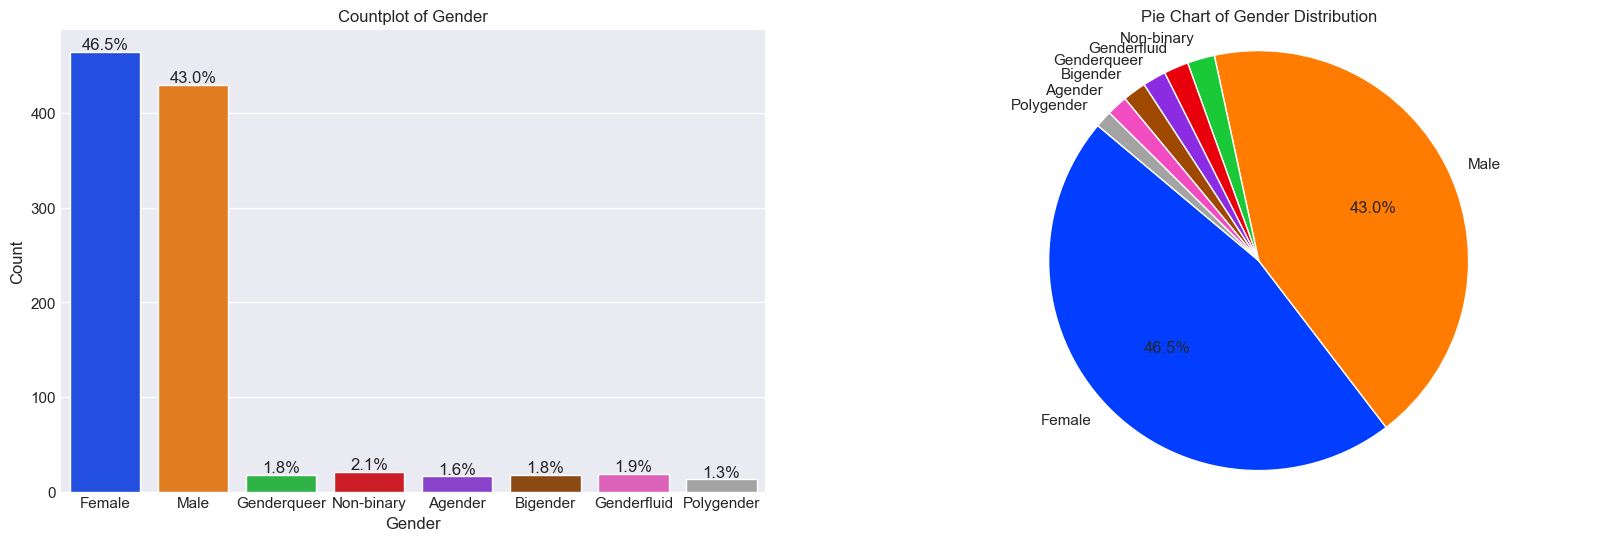

In [129]:
# Calculate the percentage of each gender
percentages = df_eda['Gender'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(1,2, figsize=(20,6))
# Plot the countplot
sns.countplot(data=df, x='Gender',ax=ax[0])

# Add percentages as text labels on top of each bar
for p in ax[0].patches:
    height = p.get_height()
    ax[0].annotate(f'{height/len(df)*100:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

ax[0].set(xlabel='Gender', ylabel='Count')
ax[0].set_title('Countplot of Gender')

# Define the threshold for displaying percentage values
threshold = 5 

def autopct_format(pct):
    return f'{pct:.1f}%' if pct > threshold else ''

# Create a pie chart
ax[1].pie(percentages, labels=percentages.index, autopct=autopct_format, startangle=140)
ax[1].set_title('Pie Chart of Gender Distribution')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


<u>Observations</u>

From the two graphs, we can see that we have more females compared to male with both taking up 46.5% and 43.0% of the distribution respectively while the other percantages are those that are LGBTQ taking up at total of 10.5%

<b> Creating a function to group those that are LGBTQ together into category called Others</b>

In [169]:
def groupNonBinaryGender(name):
    if name != 'Female' and name!= "Male":
        return "Others"
    else:
        return name
    
df['Gender'] = df['Gender'].apply(groupNonBinaryGender)

<hr>

## Bivariative Analysis<br>
Looking for correlations between features and their relationship

<u>Heatmap</u><br>
Plotting heatmap to see correlation between features


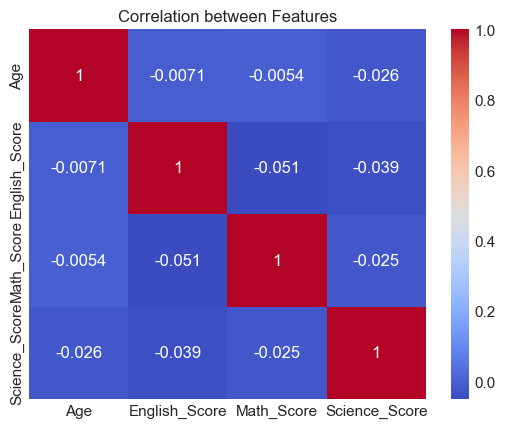

In [131]:
sns.heatmap(df_eda.drop(columns='Gender').corr(), annot=True, cmap='coolwarm').set(title="Correlation between Features")
plt.show()

<u>Observation</u>
<ul>
    <li>From the heatmap, we can conclude that there is very less correlation between any of the features as correlation value for all are close to 0 </li>
    <li>This shows that the student performance in other subject does not affect their performance in other subject and thath their age does not affect the performance as well
</ul>

<u>Pairplot</u><br>
Plotting pairplot to see trends between features

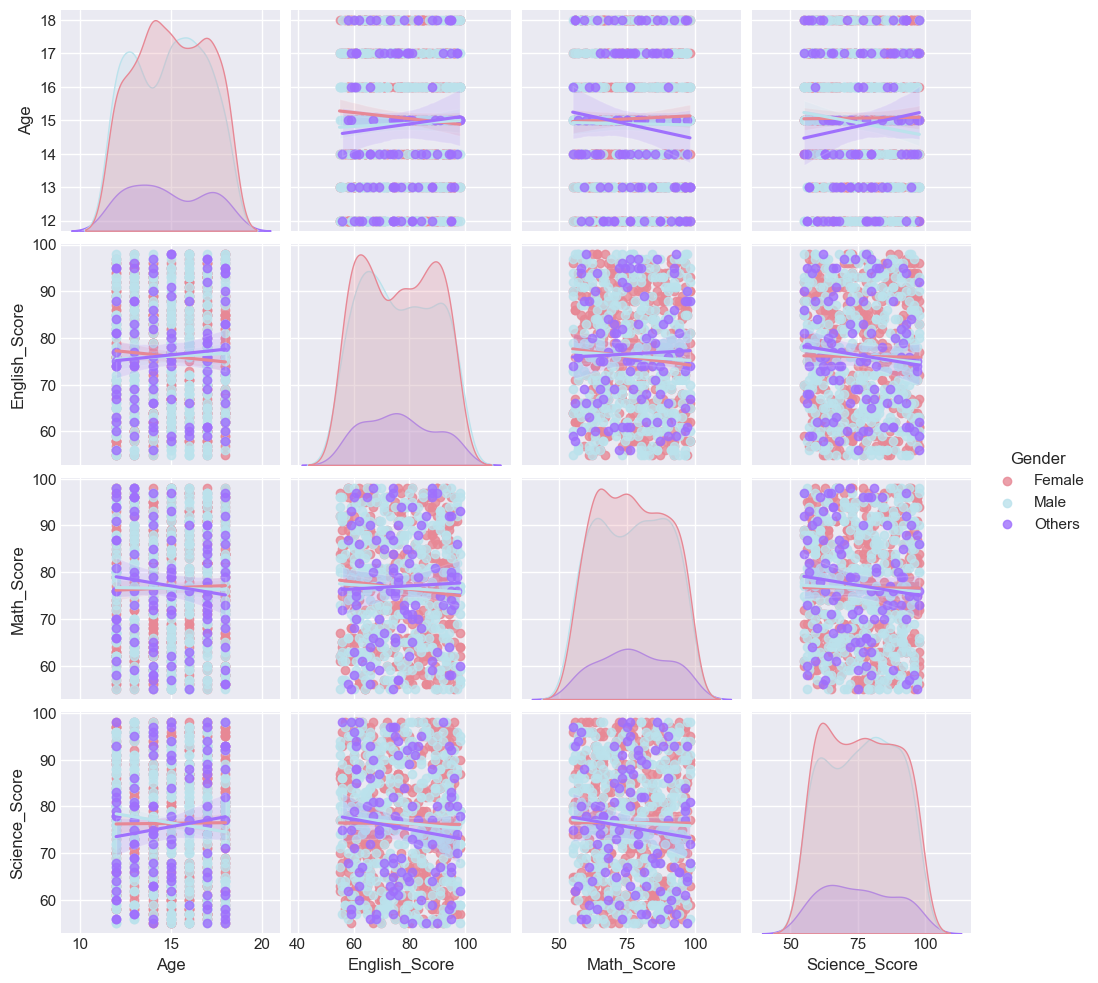

In [132]:
palette=['#E78895', '#BBE2EC', '#9F70FD']
sns.pairplot(df_eda, kind='reg', hue='Gender', palette=palette)
plt.show()

<u>Observation</u><br>
From the pairplot, we can see that there are no obvious trends between the features which is expected as there are weak correlation as seen from the heat map

It also shows a student can perform well iin a certain subject regardless of their age and other subjects


<hr></hr>

# Data Preparation
<hr>

### Data preprocessing
Things to do according to our EDA:
<ul>
    <li>Handle missing data</li>
    <li>Feature Engineer</li>
    <li>Scaling our data</li>
    <li>Handle categorical data</li>
</ul>

<hr>

### Imputing missing data
There are several ways to impute missing data:
<ul>
    <li>KNN Imputer</li>
    <li>Simple Imputer</li>
    <li>Drop Missing Data</li>
</ul>

Since from our EDA we discovered that there is little correlation between features we won't be using KNN Imputer, and since we do not want to drop data as it could contain important information, we will be using Simple imputer to impute the missing data with the mean value

In [133]:
cols = ['English_Score', 'Math_Score']
imputer = SimpleImputer(strategy='mean')
df.loc[:,cols] = imputer.fit_transform(df[cols])

In [134]:
df.isnull().sum()

Gender           0
Age              0
English_Score    0
Math_Score       0
Science_Score    0
dtype: int64

<hr>

### Creating new column for our data

In order to see the students overall performance, we will be getting the mean score of the three subject and create a new column

In [135]:
df['Average score'] = df[['English_Score', 'Math_Score', 'Science_Score']].mean(axis=1)
df

,Gender,Age,English_Score,Math_Score,Science_Score,Average score
0,Female,18,64.0,56.0,60,60.000000
1,Female,12,89.0,71.0,97,85.666667
2,Female,18,69.0,69.0,80,72.666667
3,Female,17,60.0,72.0,97,76.333333
4,Male,13,71.0,76.0,76,74.333333
...,...,...,...,...,...,...
995,Female,14,64.0,55.0,77,65.333333
996,Genderqueer,14,66.0,60.0,56,60.666667
997,Male,16,82.0,81.0,74,79.000000
998,Male,14,76.0,62.0,62,66.666667


<hr>

### Standardization
There are several ways we can Standardize our data such as using:
<ol>
    <li>Standard Scaler</li>
    <li>Min - Max Scaler</li>
</ol>

Standard scaler which scales the data such that the mean = 0 and standard deviation = 1.<br>
It divides each value by the standard deviation of the feature and subtract the mean of the feature from each feature:

$$\ X_{\text{scaled}} = \frac{X - \mu}{\sigma} \$$

Meanwhile, Min-Max Scaling rescales the features by subtracting the minimum value and dividing by the range (maximum minus minimum):
$$\ x_{\text{scaled}} = \frac{x - \text{min}}{\text{max} - \text{min}} \$$
<br>

Standard Scaler might be a better choice as it provides a standardized scale with mean 0 and variance 1, which is suitable for algorithms assuming Gaussian-distributed data


<u>Before Scaling:</u>

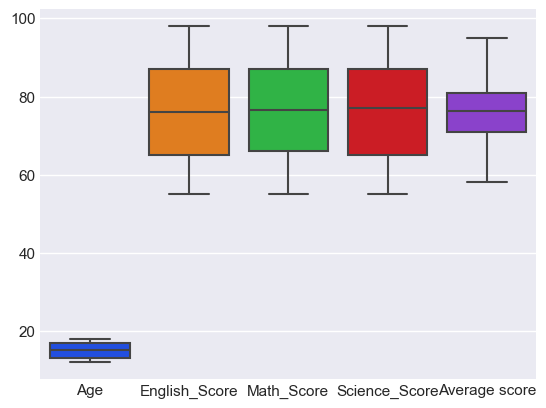

In [136]:
sns.boxplot(df)
plt.show()

In [137]:
scale = StandardScaler()
col=list(df.drop(columns='Gender').columns)
df_scaled = df.copy()
df_scaled[col] = scale.fit_transform(df_scaled[col])

<u>After Scaling:</u>

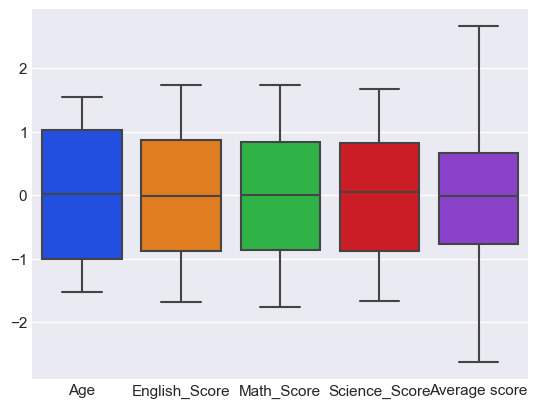

In [138]:
sns.boxplot(df_scaled)
plt.show()

<u>Observation:</u><br>
As we can see, the range of values have been standardized and most of the data takes up a range of -3 to 3. 

<hr>

### Handle categorical data

From our EDA we can see that we have a gender column that containes 7 different type of genders and there are several ways we can deal with this.
<ul>
    <li>One Hot Encoding</li>
    <li>Dropping the column</li>
</ul>

Although dropping the column could remove important information, I will be dropping the column as I blieve that students should be grouped based on their academic abilities soley and there is no need to cluster them based on their gender. I will also be showing a comparison of what happens if I don't remove gender at the end as well.

In [139]:
df_scaled.drop(columns={"Gender"}, inplace=True)

In [140]:
df_scaled.rename(columns={"English_Score": "Eng", "Math_Score": "Math", "Science_Score":"Sci", "Average score": "Avg", "Gender_Male":"Male", "Gender_Others":"Others"}, inplace=True)

In [141]:
## Only if including Gender
# df_scaled = pd.get_dummies(df_scaled)
# df_scaled

<hr>

### Finding number of K

<u>Elbow method:</u><br>
 It offers a visual approach to determining the optimal 'K' value in K-means clustering. It calculates the Within-Cluster Sum of Squares (WCSS), which measures the sum of squared distances between data points within a cluster and the centroid of that cluster.

<u>Silhoutte Coefficient:</u><br> 
The silhouette coefficient or silhouette score kmeans is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation)



In [142]:
def plot_optimalK(data):
    # Calculate the within-cluster sum of squares (inertia) for different number of clusters
    inertia = []
    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=10).fit(data)
        inertia.append(kmeans.inertia_)

    # Calculate siholute scores
    scores = []
    k_list = []
    for i, k in enumerate(np.arange(2,15)):
        # Perform k-means clustering
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(data)
        cluster_labels = kmeans.labels_

        # Calculate the silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)

        # Compute the silhoutte scores for each sample
        sample_silhoutte_values = silhouette_samples(data, cluster_labels)
        scores.append(silhouette_avg)
        k_list.append(k)
        
    fig, ax = plt.subplots(1,2, figsize=(12, 4))

    ax[0].set_title("Elbow Method For Optimal k")
    ax[0].set_xlabel("Inertia")
    ax[0].plot(range(1,15), inertia, marker='o', linestyle='-')

    ax[1].set_title("Silhouette Coefficient")
    ax[1].set_ylabel("Silhouette Coefficient")
    ax[1].set_xlabel("k")
    sns.lineplot(y=scores, x=k_list, marker='o', ax=ax[1])

    plt.suptitle("Fidning Optimal K")

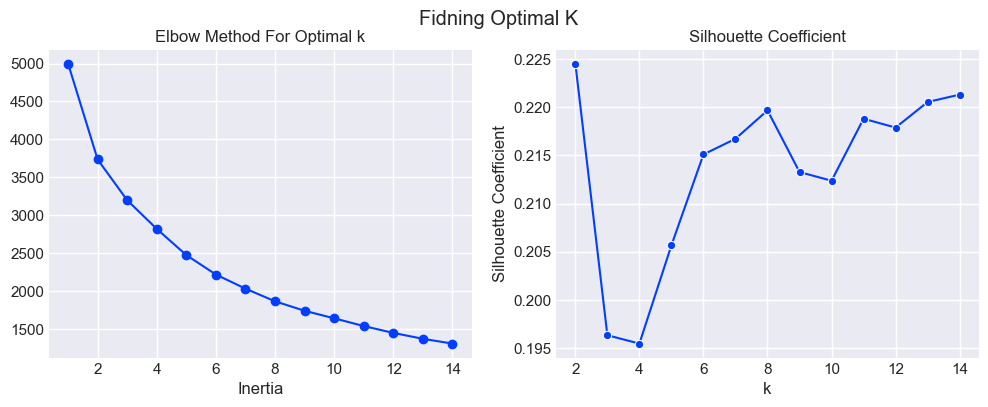

In [143]:
plot_optimalK(df_scaled)

<b><u>Observations</u></b>

<ul>
<li>Elbow Method: It is hard to see a point where the elbow point is as it resembles a curve</li>
<li>Silhouette coefficients is high at k=8 but seems to also be high at larger cluster groups of k=13 and k=14</li>
</ul>

Hence, we can take either k=8, k=13 or k=14 depedning on the number of cluster we want

### Trying to Reduce the Dimensions

When dealing with high-dimensional datasets in machine learning and data analysis, reducing the dimensionality of the data often becomes necessary for various reasons such as visualization, computational efficiency, and noise reduction. Two popular techniques for dimensionality reduction are t-SNE (t-distributed stochastic neighbor embedding) and PCA (Principal Component Analysis).

#### PCA (Principal Component Analysis)

PCA is a linear dimensionality reduction technique that aims to transform the original features of the dataset into a new set of orthogonal (uncorrelated) features called principal components. These components capture the maximum variance present in the data. By selecting a subset of these principal components, PCA effectively reduces the dimensionality of the dataset while retaining as much variance as possible. However, PCA may not capture complex non-linear relationships present in the data.

#### t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE is a non-linear dimensionality reduction technique that focuses on preserving the local structure of the data points in the high-dimensional space when mapping them to a lower-dimensional space, typically 2D or 3D. Unlike PCA, t-SNE does not make assumptions about the linearity of the data and is particularly effective at capturing complex relationships between data points. It is commonly used for visualizing high-dimensional datasets and uncovering underlying structures or clusters.

#### Scoring

We will be using silhouette score a metric used to measure the quality of clustering in the dataset after performing dimension reduction. It quantifies how well-separated clusters are, where a higher silhouette score indicates better-defined clusters

#### <u>PCA</u>

In [144]:
df_pca = df_scaled.copy()
df_pca

pca = PCA(n_components = 2)
pca_result = pca.fit_transform(df_scaled)
# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f"PC{i+1}" for i in range(2)])

# Display the PCA results
print("\nPCA Results:")
pca_df


PCA Results:


,PC1,PC2
0,-3.303930,0.526815
1,1.904533,0.565820
2,-0.777502,-0.095636
3,-0.006233,-1.170872
4,-0.364724,-0.361593
...,...,...
995,-2.157482,0.096999
996,-3.107008,0.423611
997,0.493783,0.278530
998,-1.921196,0.865623


In [145]:
palette = ['#211C6A', '#59B4C3','#74E291', '#9F70FD', '#294B29', '#E3651D', 'red', 'blue']

def plot_load(data, pca, width, height, margin=0.25, ax=None):
    # Set limits for figure
    x_max = max(pca.components_[0, :].max(), 0)+margin
    x_min = min(pca.components_[0, :].min(), 0)-margin
    y_max = max(pca.components_[1, :].max(), 0)+margin
    y_min = min(pca.components_[1, :].min(), 0)-margin

    if ax is None:
        fig, ax = plt.subplots(figsize=(width, height))
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    # Give each component own color for legend
    for i, v in enumerate(pca.components_.T):
        ax.arrow(0, 0, v[0], v[1], head_width=0.05,
                 head_length=0.1, linewidth=2, color=palette[i], label=data.columns[i])
   
    plt.plot([x_min, x_max], [0, 0], color='k', linestyle='--', linewidth=1)
    plt.plot([0, 0], [y_min, y_max], color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Loading plot", fontweight='bold')
    plt.legend(
        loc='upper left',
        bbox_to_anchor=(1, 1),
        fancybox=True,
        shadow=True,
        ncol=2)
    return ax

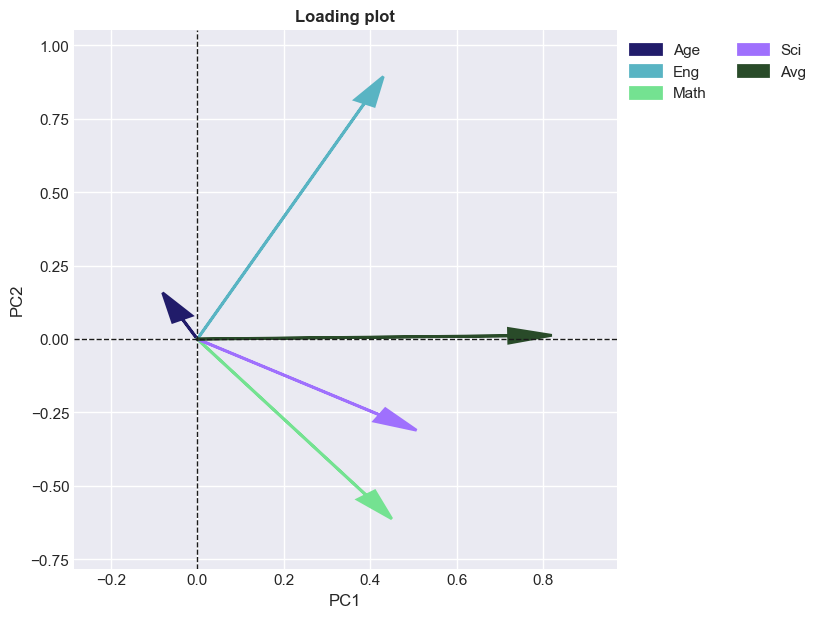

In [146]:
plt.clf
plot_load(df_scaled, pca, width=7, height=7)
plt.show() 

From the graph we can see the correlation of each feature against PC1 and PC2.
For example Avg Score has a very strong positive correlation with PC1 but has little correlation with PC2

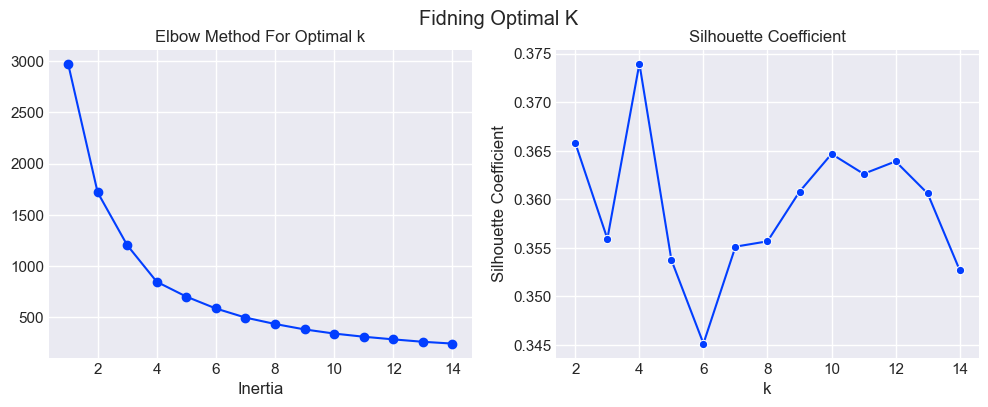

In [147]:
plot_optimalK(pca_df)

<b><u>Observations</u></b>

<ul>
<li>Elbow Method: It is hard to see a point where the elbow point is as it resembles a curve</li>
<li>Silhouette coefficients is high at k=4 and the Silhoutte Coefficient is significantly higher compared to before dimension reduction</li>
</ul>

#### <u>t-SNE</u>

In [148]:
optimal_perplexity = round(np.sqrt(df_scaled.shape[0]))
tsne = TSNE(learning_rate=50, perplexity=optimal_perplexity, random_state=42)
tsne_features = pd.DataFrame(tsne.fit_transform(df_scaled))
tsne_features

,0,1
0,-33.615574,4.172704
1,10.819115,0.263783
2,6.512330,-15.421577
3,10.656084,-19.236551
4,-6.408441,0.400578
...,...,...
995,-17.588997,-4.563219
996,-32.077431,-7.461495
997,14.861605,12.111730
998,-16.960491,14.663007


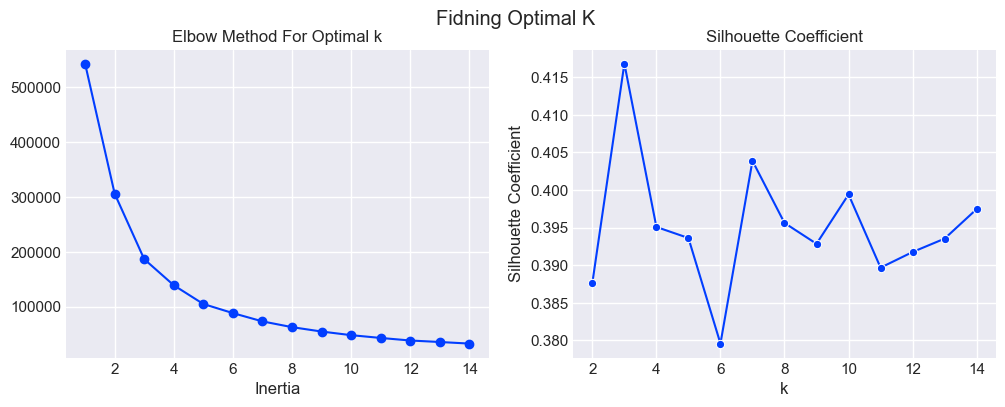

In [149]:
plot_optimalK(tsne_features)

<b><u>Observations</u></b>

<ul>
<li>Elbow Method: It is hard to see a point where the elbow point is as it resembles a curve</li>
<li>Silhouette coefficients is high at k=3 and k=7 and the Silhoutte Coefficient is significantly higher compared to before dimension reduction and PCA</li>
</ul>

Since silhouette coefficient is highest after t_SNE we will be using the it to cluster our data. We will be using k=7 as I believe that more cluster are needed to meet the needs of a variaty of student.

<hr>

### K-Means Clustering
<hr>

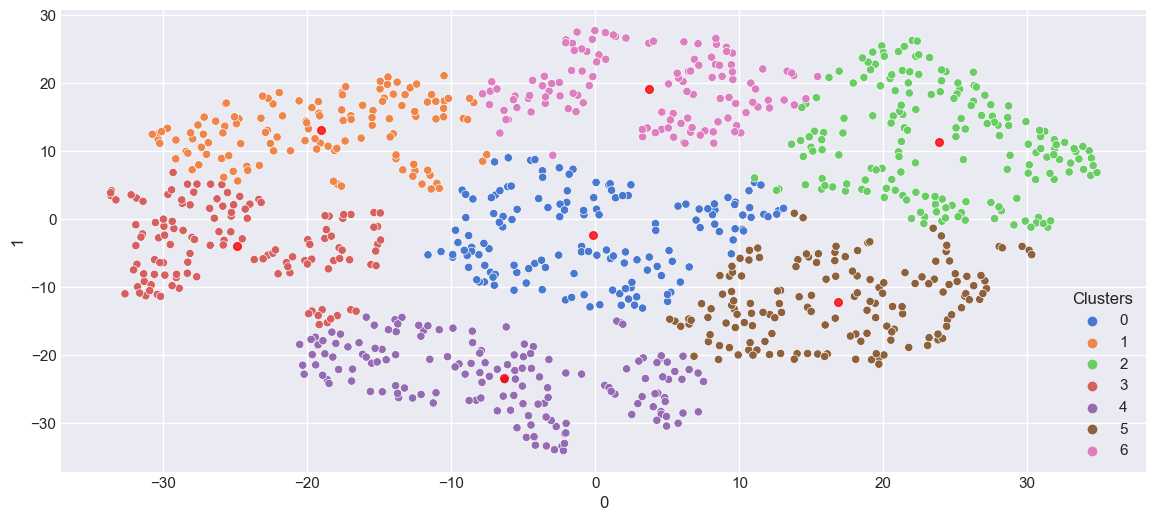

Silhouette Score(n=7): 0.4039319157600403


In [150]:
# fit a Kmeans model to the data
kMeansModel = KMeans(n_clusters=7, n_init=10)
kMeansModel.fit(tsne_features)

# Visualize the results
plt.figure(figsize=(14,6))
sns.scatterplot(x=tsne_features[0], y=tsne_features[1], hue=kMeansModel.labels_, palette='muted')

centers = kMeansModel.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=30, alpha=0.8)
plt.legend(title='Clusters')
plt.show()

print(f'Silhouette Score(n=7): {silhouette_score(tsne_features, kMeansModel.labels_)}')

<u>Observation</u><br>
We see that from the K-Means cluster, there is no overlay between clusters and that the cluster size is almost similar between clusters which means that the students are well distributed. It also has a silhouette score of 0.40 and we can say that K_Mens model is a viable choice later on.

<hr>

### Aggrolomative Hierichal Clustering

It merges the most similar clusters together, starting with each data point as a separate cluster

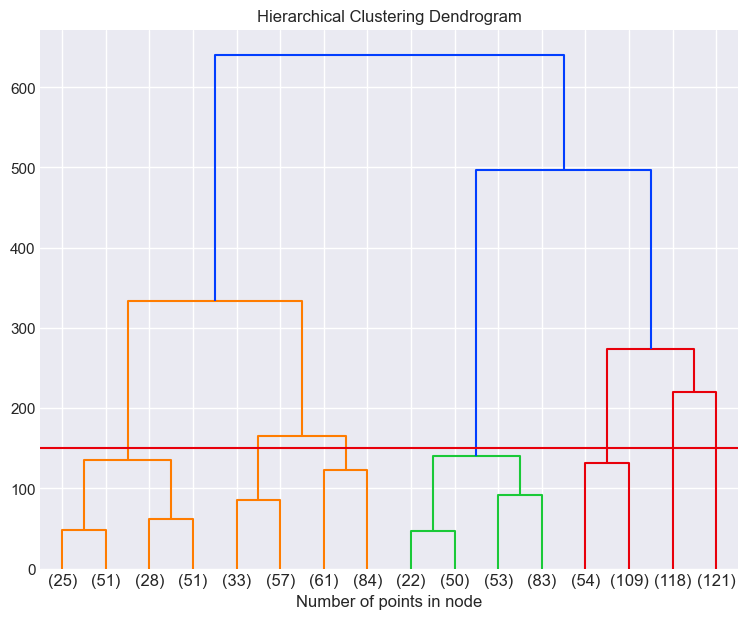

In [151]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # cCeate the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(tsne_features)

plt.figure(figsize = (9,7))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agg_cluster, truncate_mode='level', p=3)
plt.hlines(150, 0, 300, colors = 'r') # Plotting the clutering line with optimal seperation
plt.xlabel("Number of points in node")
plt.show()

From the dendogram, we can see that a cutting it off at 6 or 7 cluster is reasonable as the clusters after formed becomes less clear and defined. This observation reinforces our initial assessment that having 7 clusters is a suitable choice.

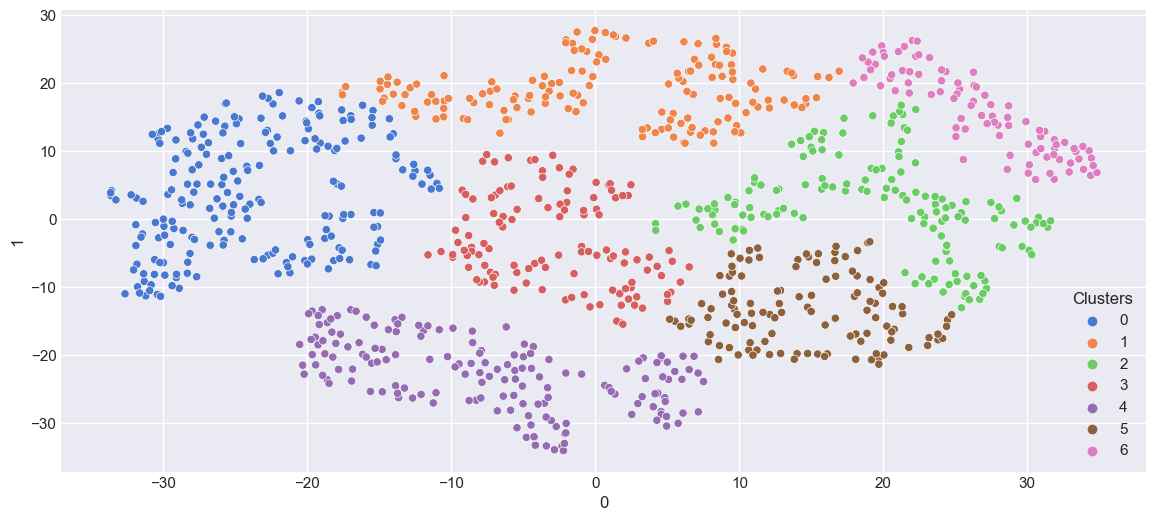

Silhouette Score(n=7): 0.365415096282959


In [152]:
hierarchical = AgglomerativeClustering(n_clusters=7)
hierarchical.fit_predict(tsne_features)

# Visualize the results
plt.figure(figsize=(14,6))

sns.scatterplot(x=tsne_features[0], y=tsne_features[1], hue=hierarchical.labels_, palette='muted')
plt.legend(title='Clusters')
plt.show()
print(f'Silhouette Score(n=7): {silhouette_score(tsne_features, hierarchical.labels_)}')


<u>Observation</u><br>
We see that from the Hierichal cluster, it is quite similar to K-Means cluster where there is no overlay between clusters and that the cluster size is almost similar between clusters which means that the students are well distributed. It also has a silhouette score of 0.37.

<hr>

### GMM Clustering

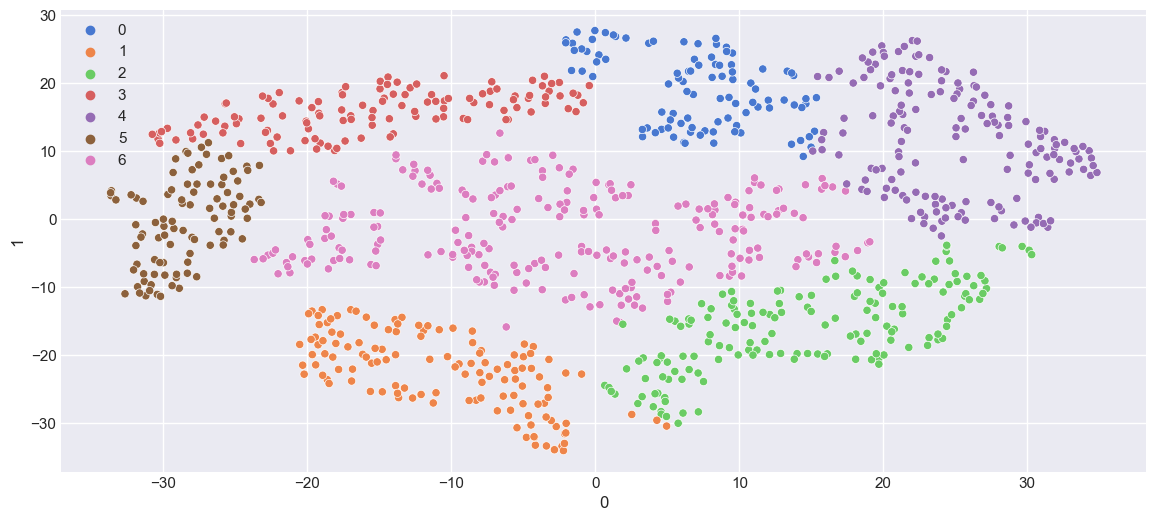

Silhouette Score(n=6): 0.33282119035720825


In [153]:
gmmModel = GaussianMixture(n_components=7, random_state=0)
gmmModel.fit(tsne_features)
labels = gmmModel.predict(tsne_features)

# Plotting
plt.figure(figsize=(14,6))
sns.scatterplot(x=tsne_features[0], y=tsne_features[1], hue=labels, palette='muted')

plt.show()
print(f'Silhouette Score(n=6): {silhouette_score(tsne_features, labels)}')


<u>Observation</u><br>
We see that from the GMM cluster, it is similar to K-Means and Hierichal cluster where there is no overlay between clusters but the cluster size is different between clusters which means that the students are not as well distributed. It also has a silhouette score of 0.33.

<hr>

### Spectral Clustering
<hr>

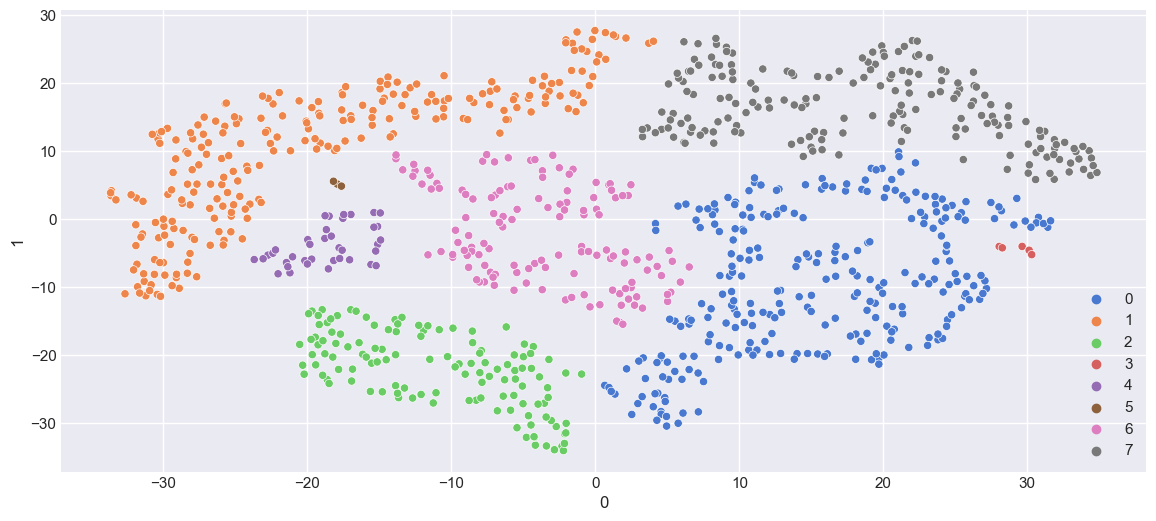

Silhouette Score(n=7): 0.07935073971748352


In [154]:
spectralClusteringModel = SpectralClustering(n_components=7, random_state=0)
spectralClusteringModel.fit(tsne_features)

# Plotting
plt.figure(figsize=(14,6))
sns.scatterplot(x=tsne_features[0], y=tsne_features[1], hue=spectralClusteringModel.labels_, palette='muted')

plt.show()
print(f'Silhouette Score(n=7): {silhouette_score(tsne_features, spectralClusteringModel.labels_)}')

<u>Observation</u><br>
Unlike the other models, the specteral cluster model results in clusters where the students are not well distributed as there are cluster where there are only very few students such as cluster 3 and cluster 5. It also has a silhouette score of 0.08 which means this model model may not be a very viable choice

<hr>

### Choosing and hypertuning our final model
<hr>

Out of the 4 models, KMeans-Clustering gave us the best silhouette score and visually we can see that the clusters all well distributed and there are no over lays. Hence, we will be using it as our final model and now will hypertune it to see if there will be any improvements


<u>Hyperparameter tuning</u>


Defining the scoring metrics

In [155]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

Training model with silhoute score as training metrics

In [156]:
#KMeans Param Grid
param_grid = {
    'n_clusters': [7],
    'init': ['k-means++', 'random'],
    'max_iter': [150, 350, 550],
    'n_init': [15, 25, 35]
}

# Create an instance of KMeans and GridSearchCV
model = KMeans(random_state=42)
km_grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=silhouette_scorer, n_jobs=-1)

km_grid_search.fit(tsne_features)

print("Best Parameters:", km_grid_search.best_params_)
print("Best Score:", km_grid_search.best_score_)

Best Parameters: {'init': 'random', 'max_iter': 150, 'n_clusters': 7, 'n_init': 25}
Best Score: 0.41215566992759706


Training model with the best parameters

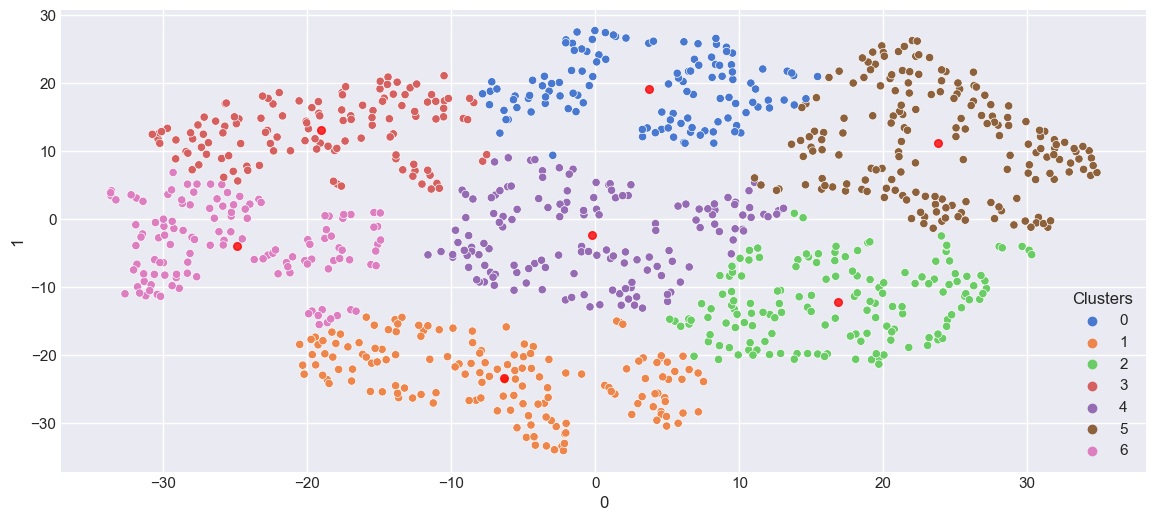

Silhouette Score(n=7): 0.4038831293582916


In [157]:
kmeans_hypertune_model = KMeans(init='random', max_iter= 150, n_clusters=7, n_init= 25)
kmeans_hypertune_model.fit(tsne_features)

# Visualize the results
plt.figure(figsize=(14,6))
sns.scatterplot(x=tsne_features[0], y=tsne_features[1], hue=kmeans_hypertune_model.labels_, palette='muted')

centers = kmeans_hypertune_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=30, alpha=0.8)
plt.legend(title='Clusters')
plt.show()

print(f'Silhouette Score(n=7): {silhouette_score(tsne_features, kmeans_hypertune_model.labels_)}')

The result is still pretty similar to our original K-Means Cluster and there is not much difference in terms of silhouette score, hence we will just proceed with this as our final model.

<hr>

### Intperating Clustering of Final Model
<hr>

#### Final Model

Assigning cluster to the students in the original dataset before scaling


In [171]:
df_eveluate = df.copy()
df_eveluate['Cluster'] = kmeans_hypertune_model.labels_

<u>Gender distribution</u>

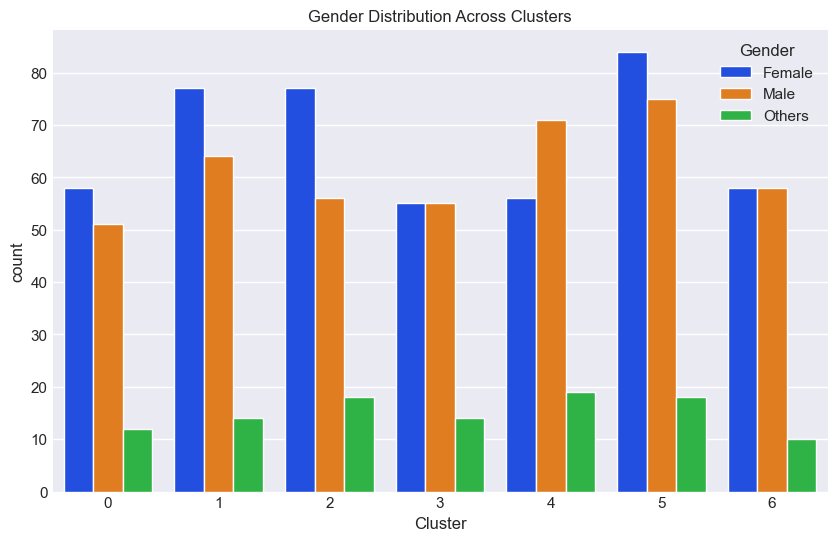

In [172]:
# Gender distribution in each cluster
plt.figure(figsize=(10,6))
plt.title('Gender Distribution Across Clusters')
sns.countplot(data=df_eveluate, x='Cluster', hue='Gender')

plt.show()

<u>Observation</u><br>
As we can see, since we did not include gender distribution across clusters, we can see that the distribution of gender is equal among all clusters and there is a trend where majority is female followed by male and lastly others, exccept for for cluster 0 and 2 where there are more male then females

<u>Inteperating the score of each clusters</u>

In [160]:
df_eveluate.drop(columns='Gender', inplace=True)

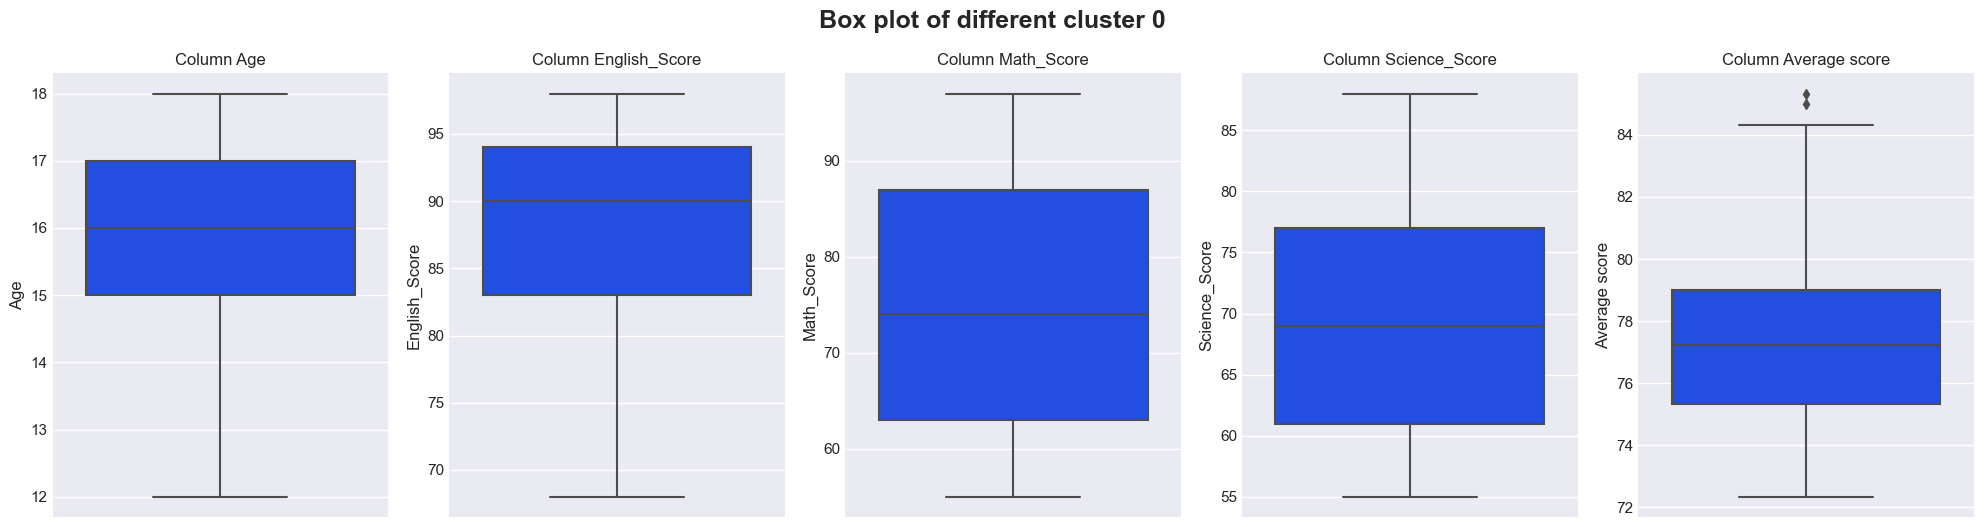

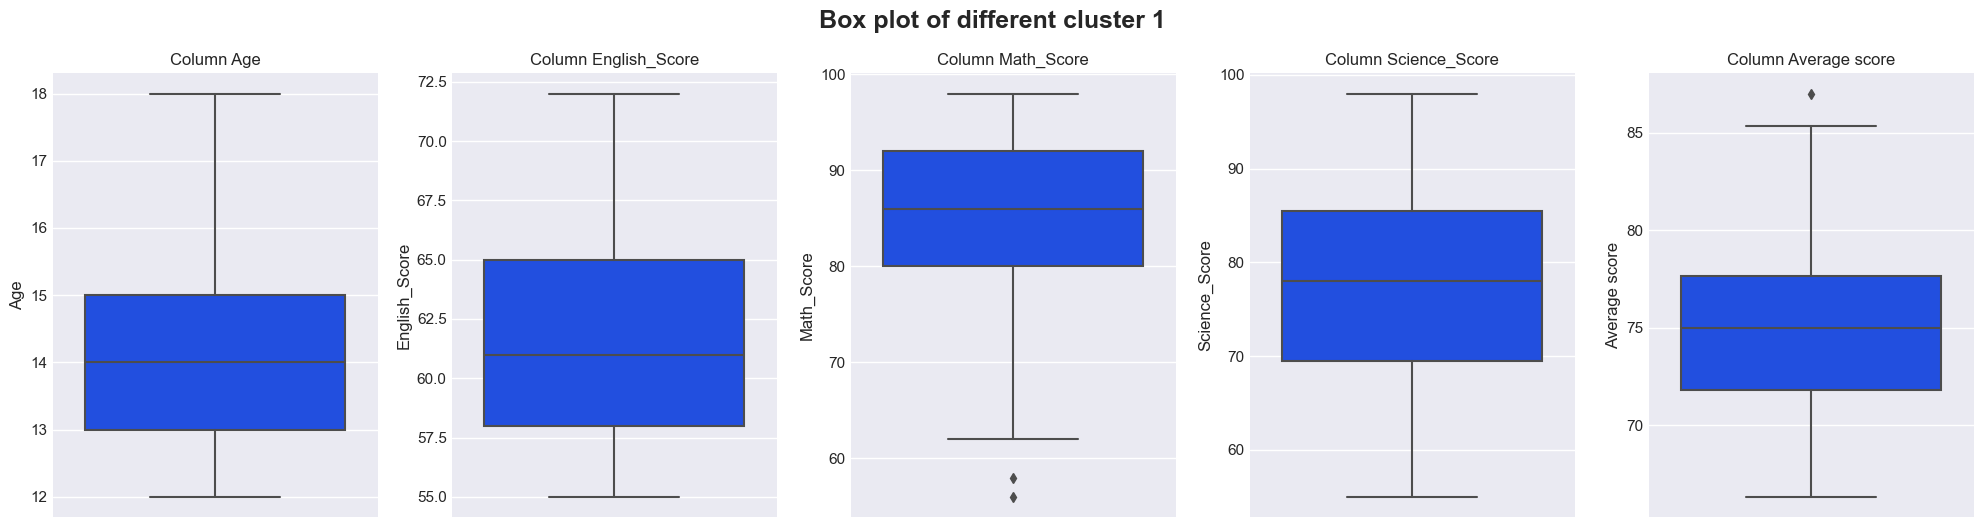

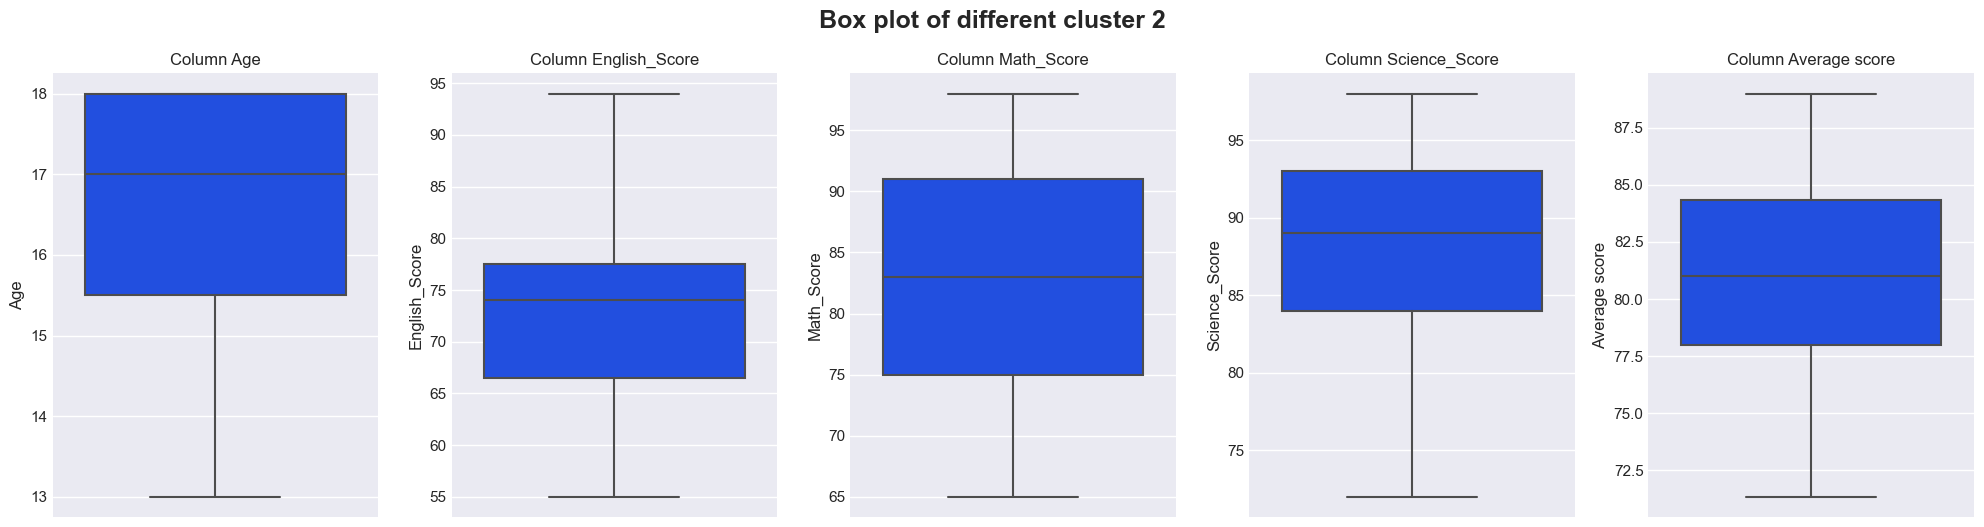

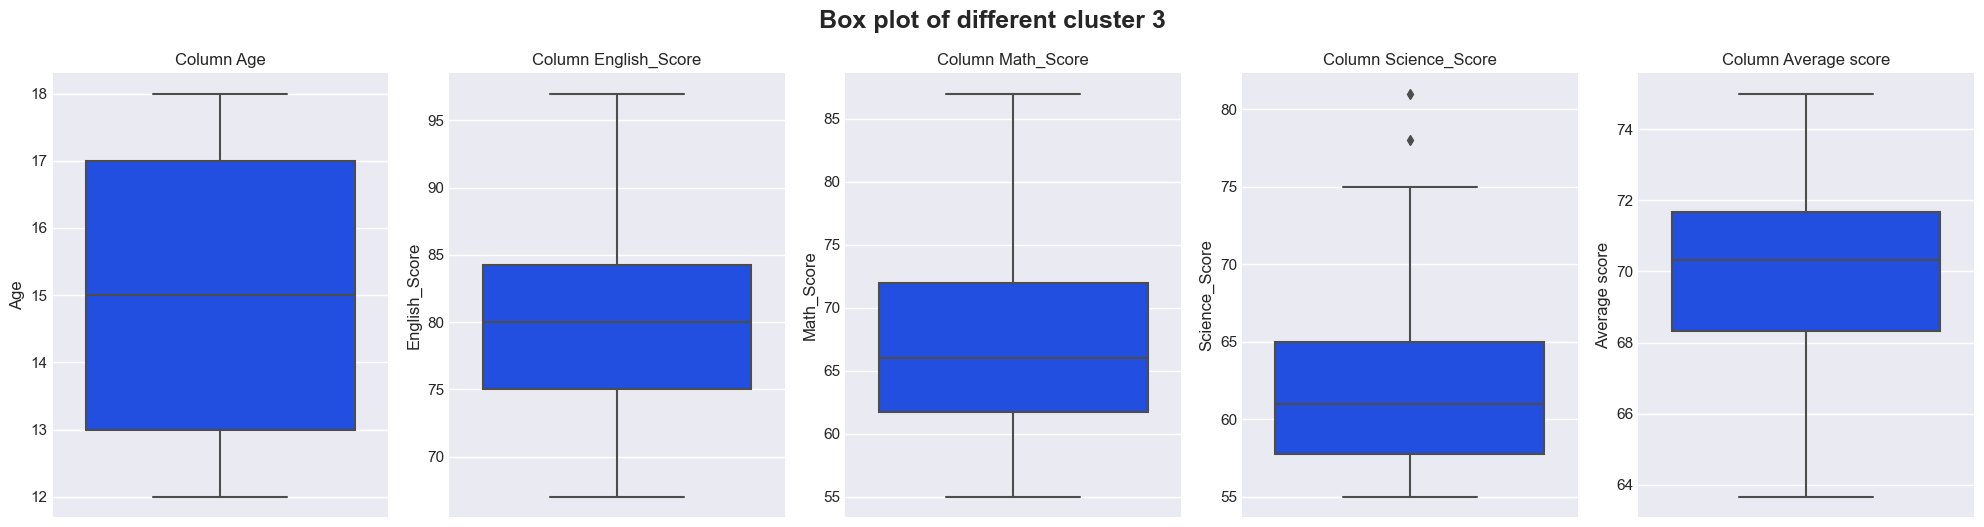

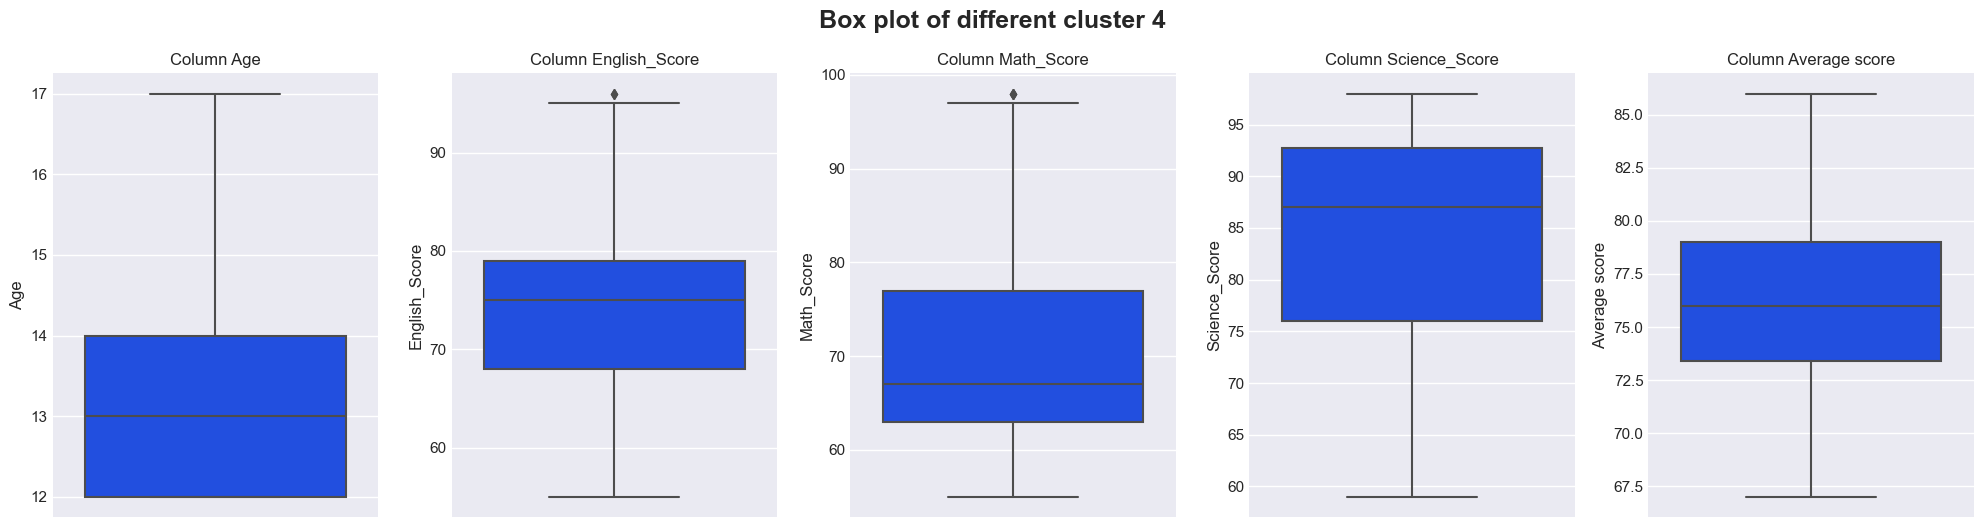

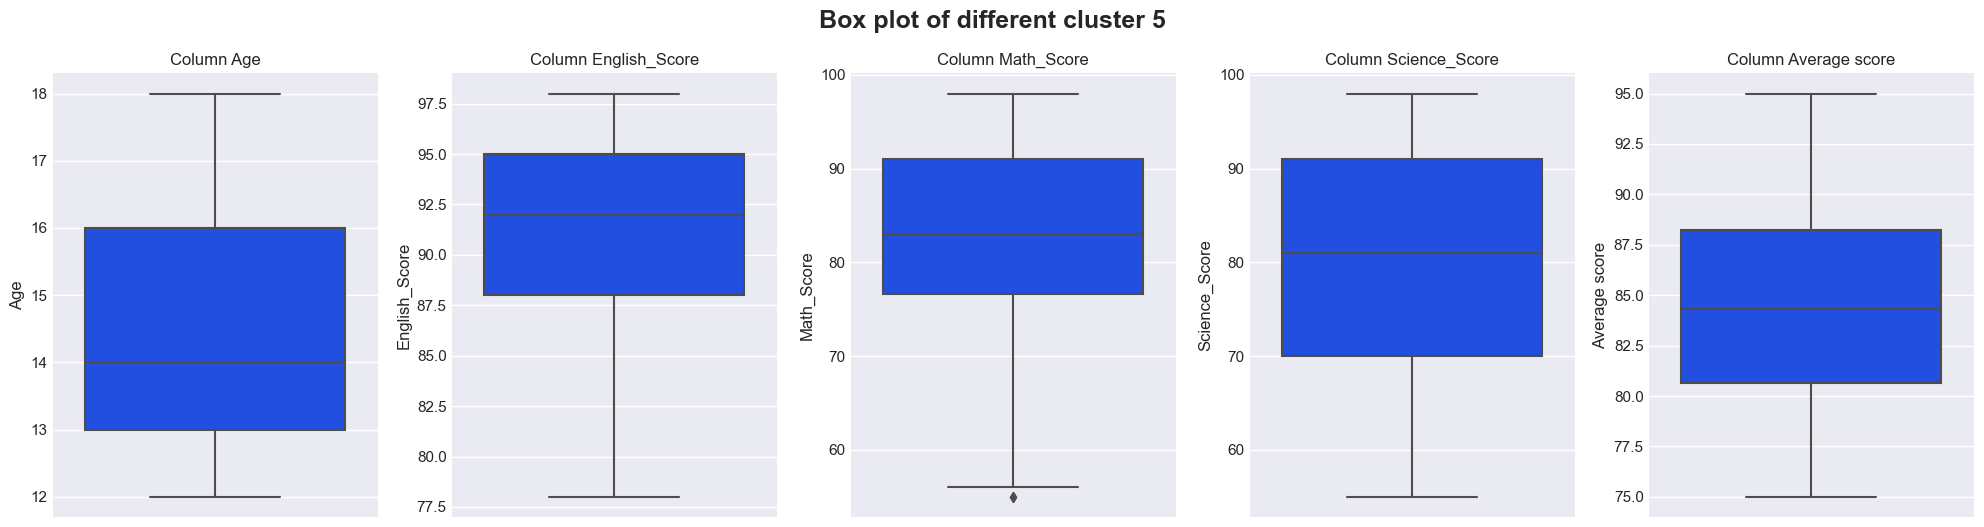

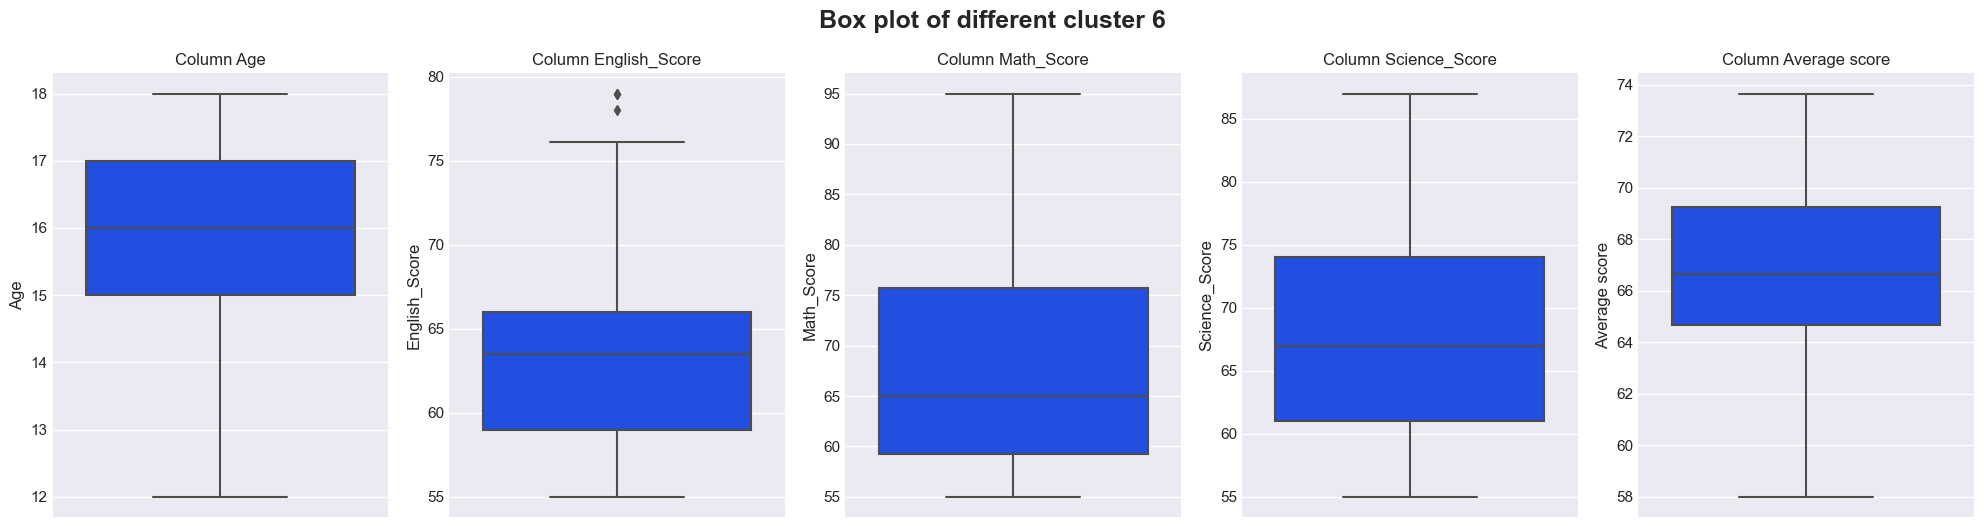

In [161]:
for k in range(7):
    cluster_df = df_eveluate[df_eveluate['Cluster'] == k]

    fig, ax = plt.subplots(1, len(cluster_df.iloc[:,:-1].columns), figsize=(20, 5))

    # Iterate over each column and create a box plot
    for i, column in enumerate(cluster_df.iloc[:,:-1].columns):
        sns.boxplot(y=cluster_df[column], ax=ax[i])
        ax[i].set_title(f'Column {column}')  # Set title for each subplot

    plt.tight_layout()
    plt.suptitle(f'Box plot of different cluster {k}', y=1.05, fontweight='bold', fontsize=18)
    plt.show()


In [162]:
cluster_centers = df_eveluate.groupby('Cluster').mean().sort_values(by='Average score', ascending=False)
cluster_centers['Cluster Size (% of Total)'] = pd.Series(df_eveluate['Cluster']).value_counts() / len(df_eveluate['Cluster']) * 100

cluster_centers

,Age,English_Score,Math_Score,Science_Score,Average score,Cluster Size (% of Total)
Cluster,,,,,,
5,14.666667,90.926554,82.962070,79.615819,84.501481,17.7
2,16.490066,72.474946,82.529685,88.119205,81.041279,15.1
0,15.942149,88.289256,74.724324,69.107438,77.373673,12.1
4,13.219178,74.247704,70.460987,84.198630,76.302440,14.6
1,14.096774,61.683871,85.677193,77.716129,75.025731,15.5
3,14.951613,80.293935,67.343897,62.000000,69.879277,12.4
6,15.761905,63.581498,67.896686,68.119048,66.532411,12.6


As we can see the cluster size of each is quite similar and cluster 4 has the most number of students while cluster 0 has the least number of students

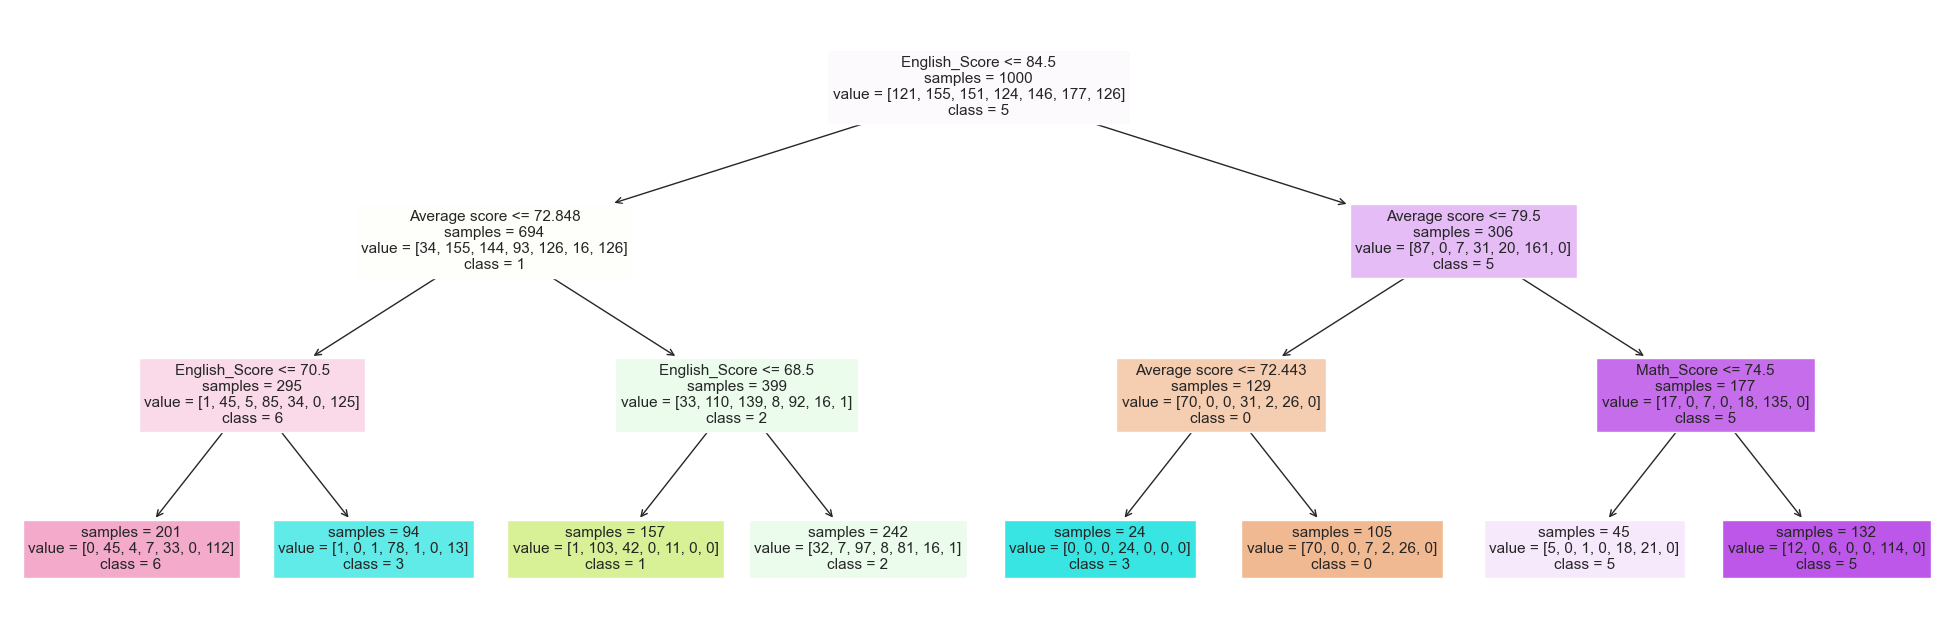

In [163]:
# Defining the model
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)
clf.fit(df_eveluate.drop(columns='Cluster'), df_eveluate['Cluster'])

# Plotting the decision tree
fig, ax = plt.subplots(figsize = (25,8))
plot_tree(
            clf,
            feature_names = df_eveluate.drop(columns='Cluster').columns,
            class_names= np.unique(df_eveluate['Cluster'].values.astype(str)),
            impurity=False,
            filled = True, 
            ax = ax, 
            fontsize=11
            )
plt.show()

<h4>Understanding each cluster</h4>

In this analysis, we have identified six customer segments based on their spending behavior and demographic characteristics.

<ol>
<li>
<b>The Weak Students</b>

Cluster 0: contains students who are weak in all subject with an mean average score of 66 marks. The cluster includes student of all ages but the median age is 16. These students are the worst performers by their average score as we can see the highest average score is 74 in this cluster.

Therefore, these students will need more attention in all subjects to help them improve their overall score<br>
</br>
</li>

<li>
<b>Little Einsteins</b> - The strong at science

Cluster 1: These students on average do well in science with a median score of 87.5 for science and are generally young students with a median of age 13. However, these students are unable to perform as well in Math and Eng but still do generally okay for these subjects with a median of 76 and 66 respectively.

Therefore, these students will need more attention in math and eng subject.
</br>
</li>

<li>
<b>The Poets</b> - Strong in Eng

Cluster 2: These students on average do well in english with a median score of 90 for english and the cluster are contains student of all ages with a median of age 16. However, these students are unable to perform as well in Math and Sci but still do generally okay for these subjects with a median of 75 and 68 respectively.

Therefore, these students will need more attention in math and science subject.

</br>
</li>

<li>
<b>Stellars</b> - Strong in all subj

Cluster 3: These students on average do well in every subject on average the median average score is 84 and the cluster contains most students aged 14, they score espacially well in english with a median 91, and 82 and 81 for math and science respectively.

Therefore, these students can be considered for special programes to let them explore their potential and be taught at a faster pace


</br>
</li>

<li>
<b>Smart Seniors</b> - Older student that are strong in most subject

Cluster 4: These students are older than usual with a median age of 17, and also do well in most subjects especially sceicne with a median score of 88 but it seems that they are weaker in english with a median score of 74.

Therefore, these students can be taught at a fast pace and may need a bit more attention on their english
</br>
</li>

<li>
<b>Mathematicians</b> - Students that are good at math

Cluster 5: These students are younger with a median age of 14 and are exceptionally good at math with a score of 85, but they do very poorly in english and moderately okay for science with scores of 62.5 and 78 respectively.

Hence, these students will need extra attention in english
</br>
</li>

<li>
<b>Bookworm</b> - Students that are good at english but very bad at STEM

Cluster 6: These students are similar to the Poets in cluster 2 where they have a good score in english of median 80 however they perform very poorly in math and science with a median of 66 and 61 respectively except for 1 outlier in each subject. This cluster has the 2nd worst average score out of the 7 Clusters 

Hence, these students will need extra attention math and science.
</br>
</li>
</ol>

<hr>

### Conclusion
<hr>

In summary, we clustered the students into 7 different clusters based on their academic abilities. Through these clusters we are able to help better meet the needs of students by grouping them based on their academics abilities allowing teachers to pace the class based on the students strenghs and weaknesseses